In [1]:
import pandas as pd
import sqlite3
from sqlite3 import Error

In [2]:
def create_connection(db_file, delete_db=False):
    import os
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)

    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)

    return conn


def create_table(conn, create_table_sql, drop_table_name=None):
    
    if drop_table_name: # You can optionally pass drop_table_name to drop the table. 
        try:
            c = conn.cursor()
            c.execute("""DROP TABLE IF EXISTS %s""" % (drop_table_name))
        except Error as e:
            print(e)
    
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def execute_sql_statement(sql_statement, conn):
    cur = conn.cursor()
    cur.execute(sql_statement)

    rows = cur.fetchall()

    return rows

import pandas as pd
df=pd.read_csv('AB_US_2020.csv')
df.to_csv('airbnb_new_data.tsv',sep='\t')


In [ ]:
'id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,city'

## GET AIRBNB DATA INTO SQL DB without city data##

In [3]:


def csv_to_db(file_name,table_name,db_name,create_sql_statement,columns):
    with open(file_name, encoding="mbcs") as fl:
        cnt=0
        data=[]
        for lines in fl:
            #print(lines)
            if cnt!=0:
                lst=lines.strip().split('\t')
                row_tmp = tuple(lst) 
                if len(row_tmp)==18:
                    data.append(row_tmp)
            cnt+=1
    ##print(data)
    conn = create_connection(db_name)
    cur = conn.cursor()
    
    ### CREATE TABLE ##
    create_table(conn,create_sql_statement,table_name)
    
    ### get number of columns
    col_num=len(columns.split(','))
    insert_sql='insert into '+str(table_name)+' values('
    for i in range(col_num):
        insert_sql+='?,'
    
    insert_sql=insert_sql[:-1]+')'
    print(insert_sql)
    
    
    cur.executemany(insert_sql,data)
    conn.commit()
    conn.close()
    
    return data


    
create_table_sql='''
 create table airbnb_data (
          row_id integer primary key not null,
          id integer,
          name text,
          host_id integer,
          host_name text,
          neighbourhood_group text,
          neighbourhood text,
          latitude real,
          longitude real,
          room_type text,
          price real,
          minimum_nights integer,
          number_of_reviews integer,
          last_review text,
          reviews_per_month real,
          calculated_host_listings_count integer,
          availability_365 integer,
          city text
        );
'''
data = csv_to_db('airbnb_new_data.tsv','airbnb_data','airbnb.db',create_table_sql,'row_id,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,city')





insert into airbnb_data values(?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)


## GET US CITY DATA INTO SQL DB ##


In [4]:
def city_state_us(file_name,db_name,table_name,columns,create_table_sql):
    with open(file_name, encoding="mbcs") as fl:
            cnt=0
            data=[]
            for lines in fl:
                ##print(lines)
                if cnt!=0:
                    lst=lines.strip().split(',')
                    row_tmp = tuple(lst)
                    data.append(row_tmp)
                cnt+=1
        
        ##print(data)
        
    conn = create_connection(db_name)
    cur = conn.cursor()

    ### CREATE TABLE ##
    create_table(conn,create_table_sql,table_name)
                
    ### get number of columns
    col_num=len(columns.split(','))
    insert_sql='insert into '+str(table_name)+' values('
    for i in range(col_num):
        insert_sql+='?,'
    insert_sql=insert_sql[:-1]+')'
    print(insert_sql)
        
    ### INSERT INTO TABLE ###
    cur.executemany(insert_sql,data)
    conn.commit()
    conn.close()
    return data

create_table_sql_city_states='''
 create table city_state_mapping (
          ID integer not null primary key,
          STATE_CODE text,
          STATE_NAME text,
          CITY text,
          COUNTY text,
          LATITUDE real,
          LONGITUDE real
        );
'''
data1= city_state_us('us_cities.csv','airbnb.db','city_state_mapping','ID,STATE_CODE,STATE_NAME,CITY,COUNTY,LATITUDE,LONGITUDE',create_table_sql_city_states)

insert into city_state_mapping values(?,?,?,?,?,?,?)


## SQL query generic function ##

In [161]:
def sql_query(sql_statement,db_name):
    conn = create_connection(db_name)
    cur = conn.cursor()
    df =pd.read_sql_query(sql_statement, conn)    
    conn.commit()
    conn.close()
    return df


## Check the city distribution of AIRBNBs ##

## CITY STATE MAPPING TABLE FORMATTED ##

In [101]:

def sql_query_create_table_as(sql_statement,db_name):
    conn = create_connection(db_name)
    cur = conn.cursor()
    cur.execute(sql)    
    conn.commit()
    conn.close()

sql='''
create table if not exists state_city_mapping_transformed as
select  id,state_code,case when substr(STATE_NAME,1,1)='"' then trim(substr(STATE_NAME,2,length(STATE_NAME)-2)) else trim(STATE_NAME) end as state_name,case when substr(COUNTY,1,1)='"' then trim(substr(COUNTY,2,length(COUNTY)-2)) else trim(COUNTY) end as county,LATITUDE,LONGITUDE,case when substr(city,1,1)='"' then trim(substr(city,2,length(city)-2)) else trim(city) end as city from city_state_mapping'''

sql_query_create_table_as(sql,'airbnb.db')


## Transformed CITY STATE dataset ##

In [103]:
sql_query('select * from state_city_mapping_transformed','airbnb.db')

,ID,STATE_CODE,state_name,county,LATITUDE,LONGITUDE,city
0,1,AK,Alaska,Aleutians West,55.999722,-161.207778,Adak
1,2,AK,Alaska,Bethel,60.891854,-161.392330,Akiachak
2,3,AK,Alaska,Bethel,60.890632,-161.199325,Akiak
3,4,AK,Alaska,Aleutians East,54.143012,-165.785368,Akutan
4,5,AK,Alaska,Kusilvak,62.746967,-164.602280,Alakanuk
...,...,...,...,...,...,...,...
29875,29876,WY,Wyoming,Washakie,44.013796,-107.956260,Worland
29876,29877,WY,Wyoming,Campbell,43.829349,-105.532327,Wright
29877,29878,WY,Wyoming,Sheridan,44.813333,-106.773333,Wyarno
29878,29879,WY,Wyoming,Park,44.853913,-110.674366,Yellowstone National Park


### API to get state names from GEOCODE ###

In [69]:
!pip install geopy


In [70]:
from geopy.geocoders import Nominatim

# initialize Nominatim API 
geolocator = Nominatim(user_agent="geoapiExercises")
Latitude = "35.65146"
Longitude = "-82.62791999999999"
location = geolocator.reverse(Latitude+","+Longitude)
address=location.raw['address']  
# Display
print(address.get('state'))

North Carolina


## UPDATED INGESTION WITH STATE NAMES ##

In [71]:


def csv_to_db(file_name,table_name,db_name,create_sql_statement,columns):
    geolocator = Nominatim(user_agent="geoapiExercises")
    
    with open(file_name, encoding="mbcs") as fl:
        cnt=0
        data=[]
        for lines in fl:
            #print(lines)
            if cnt!=0:
                
                lst=lines.strip().split('\t')
                if len(lst)==18:
                    data.append(lst)
            cnt+=1
    ##print(data)
    conn = create_connection(db_name)
    cur = conn.cursor()
    
    ### CREATE TABLE ##
    create_table(conn,create_sql_statement,table_name)
    
    
    #### GET distinct city names ###
    city={}
    for i in data:
        if i[-1] not in city.keys():
            city[i[-1]]=(i[7],i[8])
    
    
    #### mapping latitudes to states ####
    
    for i in city.keys():
        Latitude = city[i][0]
        Longitude = city[i][1]
        #print(Latitude,Longitude)
        location = geolocator.reverse(Latitude+","+Longitude)
        #print(i,location)
        address=location.raw['address']
        state=address.get('state')
        
        city[i]=state
    
    #### ADD states to existing data ###
    
    final_data=[]
    for i in data:
        i.append(city[i[-1]])
        final_data.append(tuple(i))
    
    
    ### get number of columns
    col_num=len(columns.split(','))
    insert_sql='insert into '+str(table_name)+' values('
    for i in range(col_num):
        insert_sql+='?,'
    
    insert_sql=insert_sql[:-1]+')'
    print(insert_sql)
    
    
    cur.executemany(insert_sql,final_data)
    conn.commit()
    conn.close()
    
    return data,city


    
create_table_sql='''
 create table airbnb_data_new (
          row_id integer primary key not null,
          id integer,
          name text,
          host_id integer,
          host_name text,
          neighbourhood_group text,
          neighbourhood text,
          latitude real,
          longitude real,
          room_type text,
          price real,
          minimum_nights integer,
          number_of_reviews integer,
          last_review text,
          reviews_per_month real,
          calculated_host_listings_count integer,
          availability_365 integer,
          city text,
          state text
        );
'''
data,city = csv_to_db('airbnb_new_data.tsv','airbnb_data_new','airbnb.db',create_table_sql,'row_id,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,city,state')




insert into airbnb_data_new values(?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)


In [72]:
city

{'Asheville': 'North Carolina',
 'Austin': 'Texas',
 'Boston': 'Massachusetts',
 'Broward County': 'Florida',
 'Cambridge': 'Massachusetts',
 'Chicago': 'Illinois',
 'Clark County': 'Nevada',
 'Columbus': 'Ohio',
 'Denver': 'Colorado',
 'Hawaii': 'Hawaii',
 'Jersey City': 'New Jersey',
 'Los Angeles': 'California',
 'Nashville': 'Tennessee',
 'New Orleans': 'Louisiana',
 'New York City': 'New York',
 'Oakland': 'California',
 'Pacific Grove': 'California',
 'Portland': 'Oregon',
 'Rhode Island': 'Rhode Island',
 'Salem': 'Oregon',
 'San Clara Country': 'California',
 'San Diego': 'California',
 'San Francisco': 'California',
 'San Mateo County': 'California',
 'Santa Cruz County': 'California',
 'Seattle': 'Washington',
 'Twin Cities MSA': 'Minnesota',
 'Washington D.C.': 'District of Columbia'}

In [73]:
sql=''' select * from airbnb_data_new'''
df_airbnb_listing = sql_query(sql,'airbnb.db')

## Ingest Crime Data ##

In [126]:
def create_crime_table(data_filename, normalized_database_filename):

    conn = create_connection(normalized_database_filename)
       
    create_table_crime_sql = """ CREATE TABLE [Crime] (
    [state] TEXT NOT NULL PRIMARY KEY,
    [year] Integer,
    [population] Integer,
    [property_crime] Integer,
    [burglary] Integer,
    [larceny] Integer,
    [motor] Integer,
    [violent] Integer,
    [assault] Integer, 
    [murder] Integer,
    [rape] Integer,
    [robbery] Integer
    ); """
    
    def insert_crime(conn, values):
        sql = ''' INSERT INTO Crime(state,
        year,
        population,
        property_crime,
        burglary,
        larceny,
        motor,
        violent,
        assault,
        murder,
        rape,
        robbery
        )
        VALUES(?, ?, ?, ?, ?, ?, ?, ?, ?, ?,?,?) '''
        cur = conn.cursor()
        cur.executemany(sql, values)
        conn.commit()
        conn.close()
        return cur.lastrowid    

    with open(data_filename, 'r') as f:
        crime_lst = []
        for line in f:
            if line.split(',') not in crime_lst:
                #print(line.rstrip('\n').split(','))
                crime_lst.append(line.rstrip('\n').split(','))
        crime_lst=sorted(crime_lst[1:])
        crime_lst=list(map(tuple,crime_lst))
        #print(crime_lst)
    insert_crime(conn,crime_lst)

In [127]:
data_filename = 'crime.csv'
normalized_database_filename = 'airbnb.db'
create_crime_table(data_filename, normalized_database_filename)
conn = create_connection(normalized_database_filename)
cur = conn.cursor()
df_crime_ny = pd.read_sql_query("""SELECT * FROM Crime""", conn)
display(df_crime_ny)
conn.close()

,state,year,population,property_crime,burglary,larceny,motor,violent,assault,murder,rape,robbery
0,Alabama,2019,4903185,131133,26079,92477,12577,25046,18679,358,2068,3941
1,Alaska,2019,731545,21294,3563,15114,2617,6343,4360,69,1088,826
2,Arizona,2019,7278717,177638,28699,130788,18151,33141,22704,365,3662,6410
3,Arkansas,2019,3017804,86250,18095,60735,7420,17643,13513,242,2331,1557
4,California,2019,39512223,921114,152555,626802,141757,174331,105541,1690,14799,52301
5,Colorado,2019,5758736,149189,20064,107012,22113,21938,14185,218,3872,3663
6,Connecticut,2019,3565287,50862,6441,38457,5964,6546,3742,104,771,1929
7,Delaware,2019,973764,21931,2968,17359,1604,4115,2967,48,310,790
8,District of Columbia,2019,705749,30821,1843,26645,2333,7403,4179,166,345,2713
9,Florida,2019,21477737,460846,63396,358402,39048,81270,55475,1122,8456,16217


## Ingest Covid Data ##

In [170]:
def create_covid19_table(data_filename, normalized_database_filename):

    conn = create_connection(normalized_database_filename)

    
    create_table_covid19_sql = """ CREATE TABLE [Covid19] (
    [submission_date] TEXT NOT NULL,
    [state] TEXT NOT NULL,
    [tot_cases] INTEGER,
    [conf_cases] INTEGER,
    [prob_cases] INTEGER,
    [new_case] INTEGER,
    [pnew_case] INTEGER,
    [tot_death] INTEGER, 
    [conf_death] INTEGER,
    [prob_death] INTEGER,
    [new_death] INTEGER,
    [pnew_death] INTEGER,
    [created_at] TEXT NOT NULL,
    [consent_cases] TEXT NOT NULL,
    [consent_deaths] TEXT NOT NULL
    ); """
    
    def insert_covid19(conn, values):
        insert_covid_19_sql = ''' INSERT INTO Covid19(submission_date,state,tot_cases,conf_cases,prob_cases,new_case,pnew_case,tot_death,conf_death,prob_death,new_death,pnew_death,created_at,consent_cases,consent_deaths) 
        VALUES(?, ?, ?, ?, ?, ?, ?, ?, ?,?, ?, ?, ?, ?, ?) '''
        cur = conn.cursor()
        cur.executemany(insert_covid_19_sql, values)
        return cur.lastrowid        

    with open(data_filename, 'r') as f:
        covid19_lst = []
        for line in f:
            covid19_lst.append(line.rstrip('\n').split('\t'))
        covid19_lst=sorted(covid19_lst[1:])
        #print(covid19_lst[1:10])
        
    with conn:
        lst_tup_reg=[]
        lst=[]
        create_table(conn, create_table_covid19_sql,'Covid19')
        for i in range(len(covid19_lst)):
            lst_tmp = covid19_lst[i][0].split(',')
            dt=lst_tmp[0].split('/')[2]+lst_tmp[0].split('/')[0]+lst_tmp[0].split('/')[1]
            lst_tmp[0]=int(dt)
            #lst_tup_reg.append(tuple(''.join())
            lst_tup_reg.append(lst_tmp)
        #print(lst_tup_reg[1:10])
        lst_tup_reg = list(map(tuple,lst_tup_reg))        
        insert_covid19(conn,lst_tup_reg)

        

In [180]:
data_filename = 'United_States_COVID-19_Cases_and_Deaths_by_State_over_Time.csv'
normalized_database_filename = 'airbnb.db'
create_covid19_table(data_filename,normalized_database_filename)
conn = create_connection(normalized_database_filename)
cur = conn.cursor()
df_covid = pd.read_sql_query("""SELECT * FROM Covid19""", conn)
display(df_covid)
conn.close()

,submission_date,state,tot_cases,conf_cases,prob_cases,new_case,pnew_case,tot_death,conf_death,prob_death,new_death,pnew_death,created_at,consent_cases,consent_deaths
0,20210101,AK,46241,,,470,0,285,,,4,0,01/01/2021 12:00:00 AM,N/A,N/A
1,20210101,AL,365720,298102,67618,3626,337,7267,5976,1291,82,19,01/03/2021 12:00:00 AM,Agree,Agree
2,20210101,AR,229442,,,4304,1519,3711,,,35,17,01/02/2021 02:50:51 PM,Not agree,Not agree
3,20210101,AS,3,,,0,0,0,,,0,0,01/02/2021 02:50:51 PM,,
4,20210101,AZ,530622,504153,26469,10063,1379,9015,8128,887,151,29,01/02/2021 02:50:51 PM,Agree,Agree
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41635,20201231,VT,6966,,,138,10,145,,,2,0,01/02/2021 12:00:00 AM,Not agree,Not agree
41636,20201231,WA,246413,,,3958,267,3461,,,41,0,01/02/2021 12:00:00 AM,N/A,N/A
41637,20201231,WI,520438,481102,39336,4212,402,5242,4859,383,50,9,01/01/2021 02:49:07 PM,Agree,Agree
41638,20201231,WV,85334,69506,15828,1109,-3,1338,,,20,4,01/01/2021 02:49:07 PM,Agree,Not agree


## Create Postal Mapping ##

In [234]:
def create_postal_table(data_filename, normalized_database_filename):

    conn = create_connection(normalized_database_filename)
    
    create_table_postal_sql = """ CREATE TABLE [postal] (
    [State] TEXT NOT NULL PRIMARY KEY,
    [State_Code] TEXT NOT NULL,
    [Region] TEXT NOT NULL,
    [Division] TEXT NOT NULL
    ); """
    
    def insert_postal(conn, values):
        insert_postal_sql = ''' INSERT INTO postal(State,State_Code,Region,Division) 
        VALUES(?, ?, ?, ?) '''
        cur = conn.cursor()
        cur.executemany(insert_postal_sql, values)
        conn.commit()
        return cur.lastrowid        

    with open(data_filename, 'r') as f:
        postal_lst = []
        for line in f:
            postal_lst.append(line.rstrip('\n').split('\t'))
        postal_lst=sorted(postal_lst[1:])
        ##print(postal_lst[1:10])
        
    with conn:
        lst_tup_reg=[]
        lst=[]
        create_table(conn, create_table_postal_sql,'postal')
        for i in range(len(postal_lst)):
            lst_tup_reg.append(tuple(''.join(postal_lst[i]).split(',')))
        #print(lst_tup_reg[1:10])
        insert_postal(conn,lst_tup_reg)

In [235]:
data_filename = 'us_census_bureau_regions_and_divisions.csv'
normalized_database_filename = 'airbnb.db'
create_postal_table(data_filename,normalized_database_filename)
conn = create_connection(normalized_database_filename)
cur = conn.cursor()
df_postal = pd.read_sql_query("""SELECT * FROM postal""", conn)
display(df_postal)
conn.close()

,State,State_Code,Region,Division
0,Alabama,AL,South,East South Central
1,Alaska,AK,West,Pacific
2,Arizona,AZ,West,Mountain
3,Arkansas,AR,South,West South Central
4,California,CA,West,Pacific
5,Colorado,CO,West,Mountain
6,Connecticut,CT,Northeast,New England
7,Delaware,DE,South,South Atlantic
8,District of Columbia,DC,South,South Atlantic
9,Florida,FL,South,South Atlantic


## create Income table 

In [258]:
def create_income_table(data_filename, normalized_database_filename):

    conn = create_connection(normalized_database_filename)
    
    create_table_income_sql = """ CREATE TABLE [income] (
    [State] TEXT NOT NULL PRIMARY KEY,
    [median_income] Integer
    ); """
    
    def insert_income(conn, values):
        insert_income_sql = ''' INSERT INTO income(State,median_income) 
        VALUES(?, ?) '''
        cur = conn.cursor()
        cur.executemany(insert_income_sql, values)
        conn.commit()
        return cur.lastrowid        

    with open(data_filename, 'r') as f:
        income_lst = []
        for line in f:
            income_lst.append(line.rstrip('\n').split('\t'))
        income_lst=sorted(income_lst[1:])
        #print(income_lst[1:10])
        
    with conn:
        lst_tup_reg=[]
        lst=[]
        create_table(conn, create_table_income_sql,'income')
        for i in range(len(income_lst)):
            lst_tup_reg.append(tuple(''.join(income_lst[i]).split(',')))
        #print(lst_tup_reg[1:10])
        insert_income(conn,lst_tup_reg)

In [259]:
data_filename = 'median_household_income.csv'
normalized_database_filename = 'airbnb.db'
create_income_table(data_filename, normalized_database_filename)
conn = create_connection(normalized_database_filename)
cur = conn.cursor()
df = pd.read_sql_query("""SELECT * FROM income""", conn)
conn.close()
df

,State,median_income
0,Alabama,54393
1,Alaska,74476
2,Arizona,66628
3,Arkansas,50540
4,California,77358
5,Colorado,82611
6,Connecticut,79043
7,Delaware,69132
8,District of Columbia,88311
9,Florida,57435


## NORMALIZE DATASET ##

## All Datasets ingested ##

In [81]:
df_airbnb_listing

,row_id,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,city,state
0,0,38585,Charming Victorian home - twin beds + breakfast,165529,Evelyne,,28804,35.651460,-82.627920,Private room,60.0,1,138,16/02/20,1.14,1,0,Asheville,North Carolina
1,1,80905,French Chic Loft,427027,Celeste,,28801,35.597790,-82.555400,Entire home/apt,470.0,1,114,07/09/20,1.03,11,288,Asheville,North Carolina
2,2,108061,Walk to stores/parks/downtown. Fenced yard/Pet...,320564,Lisa,,28801,35.606700,-82.555630,Entire home/apt,75.0,30,89,30/11/19,0.81,2,298,Asheville,North Carolina
3,3,155305,Cottage! BonPaul + Sharky's Hostel,746673,BonPaul,,28806,35.578640,-82.595780,Entire home/apt,90.0,1,267,22/09/20,2.39,5,0,Asheville,North Carolina
4,4,160594,Historic Grove Park,769252,Elizabeth,,28801,35.614420,-82.541270,Private room,125.0,30,58,19/10/15,0.52,1,0,Asheville,North Carolina
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225397,226025,45506143,"""DC Hidden In Plain """"Site""""""",25973146,Marci,,"Downtown, Chinatown, Penn Quarters, Mount Vern...",38.903880,-77.029730,Entire home/apt,104.0,1,0,,,2,99,Washington D.C.,District of Columbia
225398,226026,45511428,DC 3 BR w/ screen porch 3 blck to metro w/ par...,231133074,Thomas,,"Brookland, Brentwood, Langdon",38.920820,-76.990980,Entire home/apt,151.0,2,0,,,1,300,Washington D.C.,District of Columbia
225399,226027,45514685,Charming Penthouse Apt w/ Rooftop Terrace in L...,33758935,Bassem,,"Shaw, Logan Circle",38.911170,-77.033540,Entire home/apt,240.0,2,0,,,1,173,Washington D.C.,District of Columbia
225400,226028,45516412,Adams Morgan/Nat'l Zoo 1 BR Apt #32,23193071,Michael,,"Kalorama Heights, Adams Morgan, Lanier Heights",38.926630,-77.044360,Entire home/apt,60.0,21,0,,,5,362,Washington D.C.,District of Columbia


In [131]:
df_crime_ny

,state,year,population,property_crime,burglary,larceny,motor,violent,assault,murder,rape,robbery
0,Alabama,2019,4903185,131133,26079,92477,12577,25046,18679,358,2068,3941
1,Alaska,2019,731545,21294,3563,15114,2617,6343,4360,69,1088,826
2,Arizona,2019,7278717,177638,28699,130788,18151,33141,22704,365,3662,6410
3,Arkansas,2019,3017804,86250,18095,60735,7420,17643,13513,242,2331,1557
4,California,2019,39512223,921114,152555,626802,141757,174331,105541,1690,14799,52301
5,Colorado,2019,5758736,149189,20064,107012,22113,21938,14185,218,3872,3663
6,Connecticut,2019,3565287,50862,6441,38457,5964,6546,3742,104,771,1929
7,Delaware,2019,973764,21931,2968,17359,1604,4115,2967,48,310,790
8,District of Columbia,2019,705749,30821,1843,26645,2333,7403,4179,166,345,2713
9,Florida,2019,21477737,460846,63396,358402,39048,81270,55475,1122,8456,16217


## Exploratory Data Analysis ##

### Declaring a generic plotting function ###

In [242]:
def plot_graphs(kind,x,y,sql_query,normalized_database_filename):
    conn = create_connection(normalized_database_filename)
    cur = conn.cursor()
    df = pd.read_sql_query(sql_query, conn)
    #print(df)
    conn.commit()
    conn.close()
    df.plot(kind=kind,x=x,y=y)


## WHICH region had the most AIRBnBs ? ##

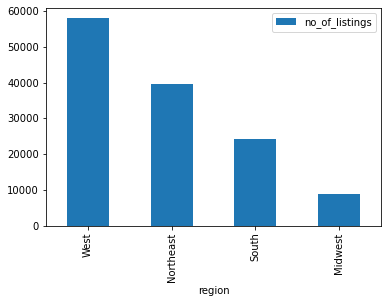

In [243]:
query = '''
SELECT b.region as region,
count(distinct a.host_id) as no_of_listings 
FROM airbnb_data_new a
left join postal b
on trim(lower(a.state)) = trim(lower(b.state))
group by b.region 
order by no_of_listings desc;'''


x='region'
y='no_of_listings'
kind='bar'
normalized_database_filename='airbnb.db'
plot_graphs(kind,x,y,query,normalized_database_filename)

### Which state had the most AirBnBs in 2020??

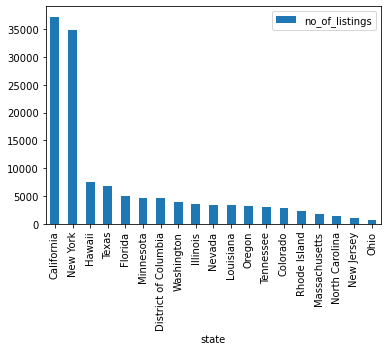

In [95]:
query = 'SELECT state,count(distinct host_id) as no_of_listings FROM airbnb_data_new group by state order by no_of_listings desc;'
x='state'
y='no_of_listings'
kind='bar'
normalized_database_filename='airbnb.db'
plot_graphs(kind,x,y,query,normalized_database_filename)

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

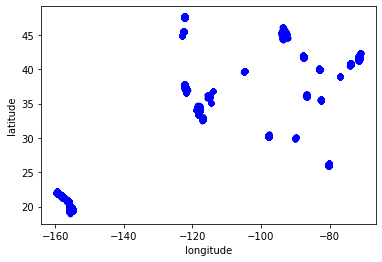

In [86]:
df_airbnb_listing.plot(x="longitude", y="latitude", kind="scatter", c="blue",
        colormap="YlOrRd")

### Which city had the most AirBnBs ? ###

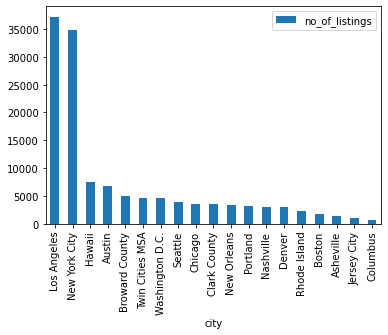

In [132]:
query = 'SELECT city,count(distinct host_id) as no_of_listings FROM airbnb_data_new group by state order by no_of_listings desc;'
x='city'
y='no_of_listings'
kind='bar'
normalized_database_filename='airbnb.db'
plot_graphs(kind,x,y,query,normalized_database_filename)

### Which Region has the most Crime Cases? ###

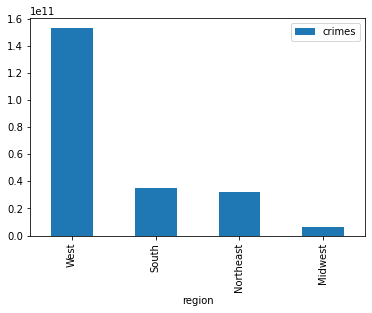

In [245]:
query = '''

SELECT b.region as region,
sum(property_crime+burglary+larceny+motor+violent+assault+murder+rape+robbery) as crimes
FROM airbnb_data_new a
left join postal b
on trim(lower(a.state)) = trim(lower(b.state))
left join crime c
on trim(a.state) = trim(c.state) 
group by b.region 
order by crimes desc;
'''


x='region'
y='crimes'
kind='bar'
normalized_database_filename='airbnb.db'
plot_graphs(kind,x,y,query,normalized_database_filename)

### Which State has the most Crime Cases? ###

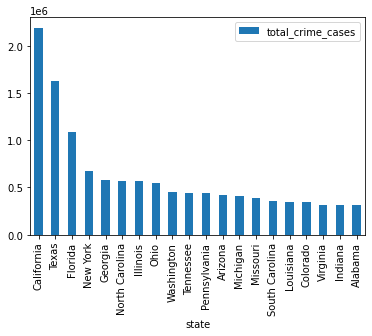

In [137]:
query = '''
SELECT state,
(property_crime+burglary+larceny+motor+violent+assault+murder+rape+robbery) as total_crime_cases
FROM crime
where state!="United States"
order by total_crime_cases desc
limit 20;'''


x='state'
y='total_crime_cases'
kind='bar'
normalized_database_filename='airbnb.db'
plot_graphs(kind,x,y,query,normalized_database_filename)

### Which Region has the biggest Crime to Population Ratio? ###


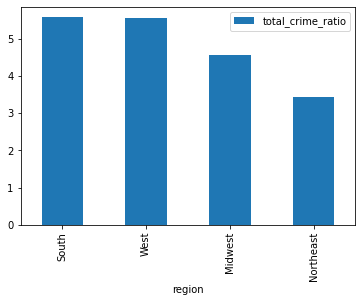

In [250]:
query = '''

SELECT b.region as region,
(sum(property_crime+burglary+larceny+motor+violent+assault+murder+rape+robbery)*100.00)/sum(population) as total_crime_ratio
FROM airbnb_data_new a
left join postal b
on trim(lower(a.state)) = trim(lower(b.state))
left join crime c
on trim(a.state) = trim(c.state) 
group by b.region 
order by total_crime_ratio desc;
'''


x='region'
y='total_crime_ratio'
kind='bar'

normalized_database_filename='airbnb.db'
plot_graphs(kind,x,y,query,normalized_database_filename)



### Which State has the biggest Crime to Population Ratio? ###

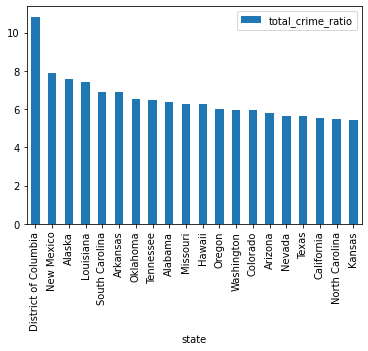

In [160]:
query = '''
select 
state,
population,
(total_crime*100.0/population) as total_crime_ratio
from
(
SELECT 
state,
population,
(property_crime+burglary+larceny+motor+violent+assault+murder+rape+robbery) as total_crime
FROM crime
where state!="United States"
)
a
order by total_crime_ratio desc
limit 20
'''


x='state'
y='total_crime_ratio'
kind='bar'

normalized_database_filename='airbnb.db'
plot_graphs(kind,x,y,query,normalized_database_filename)



## What are the different types of airbnbs available along with avg price

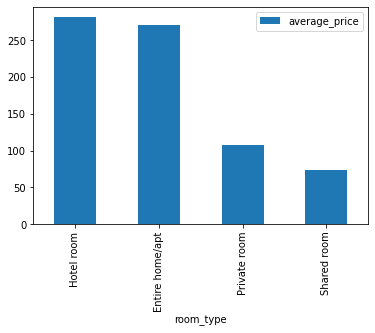

In [251]:
query = '''
select 
room_type,
avg(price) as average_price
from
airbnb_data_new
group by room_type
order by average_price desc
'''


x='room_type'
y='average_price'
kind='bar'

normalized_database_filename='airbnb.db'
plot_graphs(kind,x,y,query,normalized_database_filename)



## What is the average price of AirBnBs Regionwise?

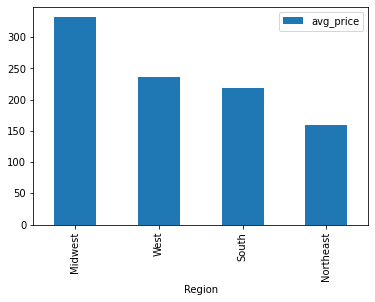

In [254]:
query = '''
select 
region,
avg(price) as avg_price
from
airbnb_data_new a
left join postal b
on trim(a.state) = trim(b.state)
group by region
order by avg_price desc
limit 20
'''

x='Region'
y='avg_price'
kind='bar'

normalized_database_filename='airbnb.db'
plot_graphs(kind,x,y,query,normalized_database_filename)


## what is the average price of Airbnbs in top 20 states ##

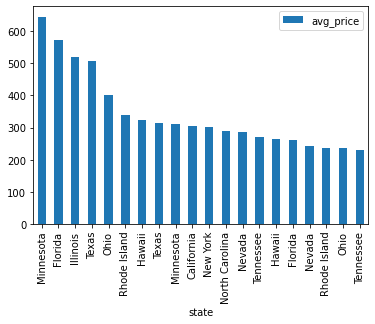

In [201]:
query = '''
select 
state,
avg(price) as avg_price
from
airbnb_data_new
group by state,
room_type
order by avg_price desc
limit 20
'''

x='state'
y='avg_price'
kind='bar'

normalized_database_filename='airbnb.db'
plot_graphs(kind,x,y,query,normalized_database_filename)


## Average Price of AirBnB in top 20 cities

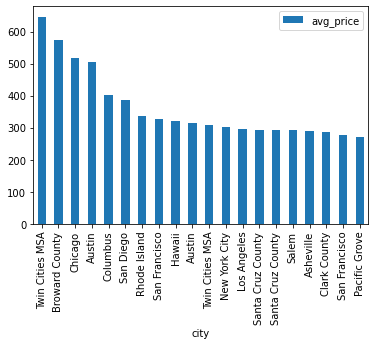

In [204]:
query = '''
select 
trim(city) as city,
avg(price) as avg_price
from
airbnb_data_new
group by trim(city),
room_type
order by avg_price desc
limit 20
'''

x='city'
y='avg_price'
kind='bar'

normalized_database_filename='airbnb.db'
plot_graphs(kind,x,y,query,normalized_database_filename)


## which {State,RoomType} combination is the most expensive?

In [195]:
query = '''
select 
state,
room_type,
max(price) as max_price
from
airbnb_data_new
group by state,
room_type
order by max_price desc
limit 20
'''
normalized_database_filename='airbnb.db'
conn = create_connection(normalized_database_filename)
cur = conn.cursor()
df_mostexpensive = pd.read_sql_query(query, conn)
display(df_mostexpensive)
conn.close()


,state,room_type,max_price
0,California,Entire home/apt,24999.0
1,Hawaii,Entire home/apt,24999.0
2,North Carolina,Entire home/apt,24999.0
3,California,Private room,15000.0
4,Minnesota,Entire home/apt,15000.0
5,Texas,Entire home/apt,11373.0
6,Louisiana,Entire home/apt,10500.0
7,California,Shared room,10000.0
8,Colorado,Entire home/apt,10000.0
9,Colorado,Private room,10000.0


## What is the income distribution across states?

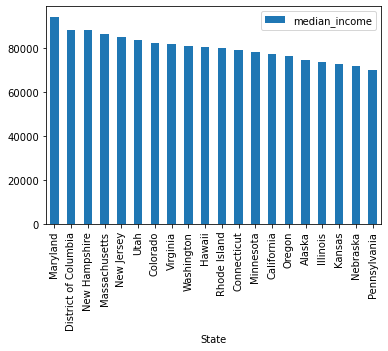

In [260]:
query = '''
select 
state,
median_income
from
income
group by state
order by median_income desc
limit 20
'''

x='State'
y='median_income'
kind='bar'

normalized_database_filename='airbnb.db'
plot_graphs(kind,x,y,query,normalized_database_filename)


## is there a correlation between median salary and airbnb prices?

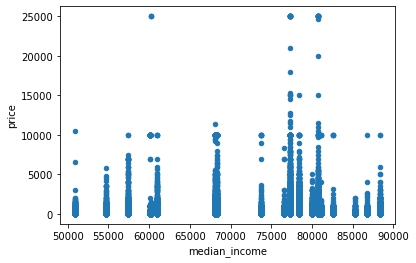

In [266]:
query = '''
select 
price,
median_income
from airbnb_data_new a
left join income b
on trim(a.state) = trim(b.state)
'''

x='median_income'
y='price'
kind='scatter'

normalized_database_filename='airbnb.db'
plot_graphs(kind,x,y,query,normalized_database_filename)


## is reviews per month related with price? ##

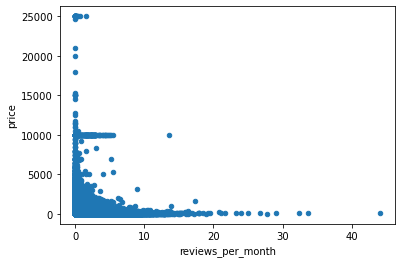

In [271]:
query = '''
select 
price,
cast(reviews_per_month as real) as reviews_per_month
from
airbnb_data_new
'''

x='reviews_per_month'
y='price'
kind='scatter'

normalized_database_filename='airbnb.db'
plot_graphs(kind,x,y,query,normalized_database_filename)


## is availability related with price? ##


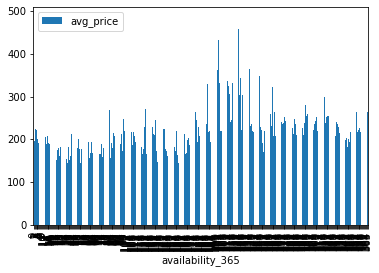

In [279]:
query = '''
select 
cast(availability_365 as integer) as availability_365,
avg(price) as avg_price
from
airbnb_data_new
group by availability_365
'''

x='availability_365'
y='avg_price'
kind='bar'

normalized_database_filename='airbnb.db'
plot_graphs(kind,x,y,query,normalized_database_filename)


### We have around 45k listings in New York ###

In [89]:
len(df_ny_airbnb_listings)

45629

In [90]:
df_ny_airbnb_listings.head(5)

,row_id,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,city,state
116796,117155,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,175.0,3,48,04/11/19,0.37,2,365,New York City,New York
116797,117156,3831,"Whole flr w/private bdrm, bath & kitchen(pls r...",4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,76.0,1,349,23/08/20,4.82,1,272,New York City,New York
116798,117157,5121,BlissArtsSpace!,7356,Garon,Brooklyn,Bedford-Stuyvesant,40.68688,-73.95596,Private room,60.0,29,50,02/12/19,0.36,1,365,New York City,New York
116799,117158,5136,"Spacious Brooklyn Duplex, Patio + Garden",7378,Rebecca,Brooklyn,Sunset Park,40.66120,-73.99423,Entire home/apt,175.0,7,1,02/01/14,0.01,1,352,New York City,New York
116800,117159,5178,Large Furnished Room Near B'wayâ€žÃ„Ã„,8967,Shunichi,Manhattan,Hell's Kitchen,40.76489,-73.98493,Private room,79.0,2,473,15/03/20,3.42,1,346,New York City,New York


In [182]:
## What is distribution of Airbnb listings in NYC ##

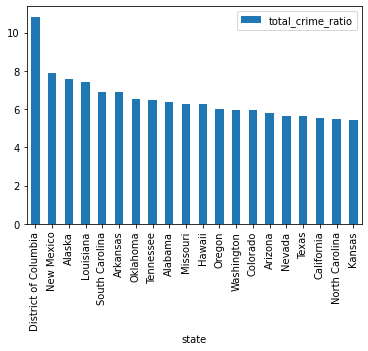

In [151]:
df['ratio'] = df['col1']/df['population']

In [156]:
df

,state,population,total_crime_ratio
0,District of Columbia,705749,10.832180
1,New Mexico,2096829,7.889914
2,Alaska,731545,7.555789
3,Louisiana,4648794,7.422570
4,South Carolina,5148714,6.903161
5,Arkansas,3017804,6.885338
6,Oklahoma,3956971,6.554155
7,Tennessee,6829174,6.495661
8,Alabama,4903185,6.370512
9,Missouri,6137428,6.267316
